In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline

from keras.callbacks import LearningRateScheduler, History
from keras.optimizers import Adam
from keras.models import Model
from keras.losses import categorical_crossentropy, hinge

import tensorflow as tf

Using TensorFlow backend.


In [2]:
import sys
sys.path.append('/home/albert/github/DenseNet/')
import densenet
sys.path.append('/home/albert/github/tensorflow/src/')
import triplet
import evaluation
import data
import models

In [3]:
P_param = 6
K_param = 4

### Data

In [4]:
train_dict, train_files = data.get_data('train', keypoints=['Neck'])

preprocess True
keypoints ['Neck']
1.00641393661


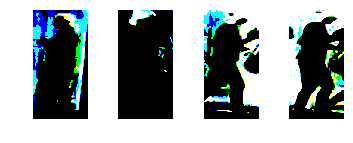

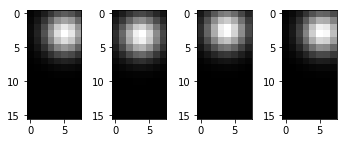

1.0
1.0
1.0
1.0


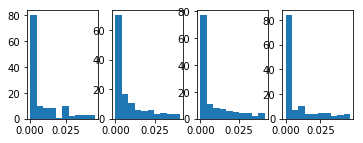

In [5]:
start = time.time()
batch = data.output_batch_generator(train_dict, P=P_param, K=K_param, preprocess=True,
                                    shape=(256,128), keypoints=['Neck'], 
                                    cam_output_dim=(16,8), rect=False).next()
print time.time() - start

plt.figure(figsize=(15,2))
for i in range(4):
    plt.subplot(1,10,i+1)
    plt.imshow(batch[0]['input_im'][i].astype(np.uint8))
    plt.axis('off')
plt.show()

import cv2
plt.figure(figsize=(15,2))
for i in range(4):
    plt.subplot(1,10,i+1)
    im = batch[1]['cam_output'][i].squeeze()
    plt.imshow(im, cmap=plt.cm.gray)
    plt.axis('on')
plt.show()

plt.figure(figsize=(15,2))
for i in range(4):
    plt.subplot(1,10,i+1)
    im = batch[1]['cam_output'][i].squeeze()
    print im.sum()
    plt.hist(im.flatten())
    plt.axis('on')
plt.show()

### Train Network

In [6]:
steps_per_epoch = 100

input_shape = (256,128)

preprocess = True

In [7]:
file_root = 'spn_neck_svd_P6K4'
if os.path.exists('/home/albert/github/tensorflow/models/%s' % file_root) == False:
    os.system('mkdir /home/albert/github/tensorflow/models/%s' % file_root)

In [8]:
# First integer: number of epochs (e.g., 10)
# Second integer: era

epochs = 10

step_decay_cont_str = """
def step_decay_cont(epoch, init_epoch=%d*(%d - 1), init_lr=0.0003):
    drop = 0.5
    epochs_drop = 10.0
    t1 = 50.0
    if epoch + init_epoch < t1:
        lrate = init_lr
    else:
        lrate = init_lr * np.power(drop,  
               np.floor((epoch + init_epoch - t1 + epochs_drop)/(epochs_drop)))
    return lrate
"""

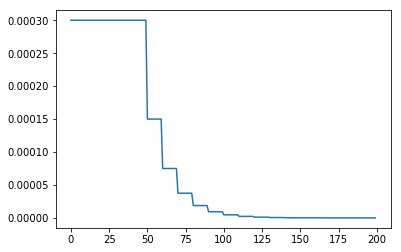

In [9]:
lr = []
for era in range(1,21):
    exec(step_decay_cont_str % (epochs, era))
    for j in range(10):
        lr.append(step_decay_cont(j))
plt.plot(np.arange(200), lr)

In [10]:
camnet = models.SPN(P_param,K_param, weights='imagenet', reduce_dim=True, pool_dim=16)

Weights for the model were loaded successfully
(24, 8, 4, 16)
(24, 8, 4, 16)


In [11]:
b = batch[0]['input_im']
spn = camnet.predict(b)

In [12]:
print spn[1][4]

[[ 0.01777182  0.02211729  0.02290869  0.02125579]
 [ 0.02304343  0.03592253  0.03364076  0.02351524]
 [ 0.02849418  0.04389039  0.04017464  0.02799926]
 [ 0.03015898  0.04897593  0.04342844  0.03168752]
 [ 0.03098254  0.0462374   0.04454833  0.03095121]
 [ 0.02882065  0.04244016  0.0385087   0.03037132]
 [ 0.02487528  0.03871133  0.03719503  0.02543987]
 [ 0.0192489   0.02528422  0.02361616  0.01778399]]


1.0


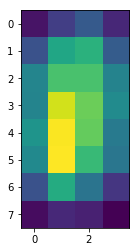

In [13]:
print spn[1][2].sum()
plt.imshow(spn[1][0].reshape((8,4)))

In [14]:
import keras
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.final_output_loss = []
        self.cam_output_loss = []
        
    def on_epoch_end(self, epoch, logs={}):
#         print logs.keys()
        self.loss.append(logs['loss'])
        self.final_output_loss.append(logs['final_output_loss'])
        self.cam_output_loss.append(logs['cam_output_loss'])
    
    def on_train_end(self, logs={}):
        print self.loss, self.final_output_loss, self.cam_output_loss

In [15]:
model_json = camnet.to_json()
with open("/home/albert/github/tensorflow/models/%s/%s.json" % (file_root, file_root), "w") as json_file:
    json_file.write(model_json)

In [16]:
# camnet.set_weights(np.load('/home/albert/github/tensorflow/models/spn_neck_svd_P6K4/spn_neck_svd_P6K4_1000.npy'))

In [17]:
train_score = {}
hist = {'loss' : [], 'final_output_loss' : [], 'cam_output_loss' : []}
history = History()
loss = LossHistory()

In [18]:
for era in range(1,16):
    iterations = era * steps_per_epoch * epochs
    exec(step_decay_cont_str % (epochs, era))
    lrate = LearningRateScheduler(step_decay_cont)
    
    camnet.fit_generator(data.output_batch_generator(train_dict, P=P_param, K=K_param, preprocess=True,
                                    shape=(256,128), keypoints=['Neck'], 
                                    cam_output_dim=(8,4), rect=False), 
                         steps_per_epoch=steps_per_epoch,
                         epochs=epochs,
                         callbacks=[lrate, history, loss])
    
    file_name = file_root + '_' + str(iterations) + '.npy'
    np.save('/home/albert/github/tensorflow/models/%s/%s' % (file_root, file_name), camnet.get_weights())
    
    camnet_test = models.load_model('/home/albert/github/tensorflow/pre/pre3/models/densenet_triplet/densenet_triplet.json',
                                    weights_file='/home/albert/github/tensorflow/models/%s/%s' % (file_root, file_name))
    train_score[iterations] = evaluation.get_score(camnet_test, hist=history, preprocess=preprocess, cover=True)
    
    hist['loss'] += loss.loss
    hist['final_output_loss'] += loss.final_output_loss
    hist['cam_output_loss'] += loss.cam_output_loss
    
    print iterations, train_score[iterations]

preprocess True
keypoints ['Neck']
Epoch 1/10
100/100 [==============================] - 188s - loss: 958.0740 - final_output_loss: 386.0296 - cam_output_loss: 23.8222   
Epoch 2/10
100/100 [==============================] - 181s - loss: 783.7048 - final_output_loss: 256.2105 - cam_output_loss: 21.9658   
Epoch 3/10
100/100 [==============================] - 181s - loss: 663.9251 - final_output_loss: 215.8673 - cam_output_loss: 18.6559   
Epoch 4/10
100/100 [==============================] - 182s - loss: 555.9354 - final_output_loss: 198.1712 - cam_output_loss: 14.8936   
Epoch 5/10
100/100 [==============================] - 181s - loss: 435.5926 - final_output_loss: 173.4342 - cam_output_loss: 10.9100   
Epoch 6/10
100/100 [==============================] - 181s - loss: 371.6235 - final_output_loss: 152.0203 - cam_output_loss: 9.1368   
Epoch 7/10
100/100 [==============================] - 181s - loss: 331.6833 - final_output_loss: 142.1788 - cam_output_loss: 7.8827   
Epoch 8/10
100/

100/100 [==============================] - 185s - loss: 133.0436 - final_output_loss: 38.8546 - cam_output_loss: 3.9107   
Epoch 2/10
100/100 [==============================] - 181s - loss: 137.2744 - final_output_loss: 46.6915 - cam_output_loss: 3.7604   
Epoch 3/10
100/100 [==============================] - 182s - loss: 138.0268 - final_output_loss: 41.8896 - cam_output_loss: 3.9918   
Epoch 4/10
100/100 [==============================] - 182s - loss: 142.0904 - final_output_loss: 47.6613 - cam_output_loss: 3.9206   
Epoch 5/10
100/100 [==============================] - 181s - loss: 129.6356 - final_output_loss: 39.4841 - cam_output_loss: 3.7423   
Epoch 6/10
100/100 [==============================] - 182s - loss: 122.8471 - final_output_loss: 32.3594 - cam_output_loss: 3.7563   
Epoch 7/10
100/100 [==============================] - 181s - loss: 118.3231 - final_output_loss: 32.2166 - cam_output_loss: 3.5737   
Epoch 8/10
100/100 [==============================] - 182s - loss: 131.39

ResourceExhaustedError: OOM when allocating tensor with shape[24,1024,1024]
	 [[Node: cam_output/transpose = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:localhost/replica:0/task:0/gpu:0"](cam_output/StopGradient_2, cam_output/transpose/perm)]]
	 [[Node: loss/add_62/_5479 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_194603_loss/add_62", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'cam_output/transpose', defined at:
  File "/home/albert/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/albert/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/albert/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/albert/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/albert/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/albert/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/albert/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-59875dab7ce6>", line 1, in <module>
    camnet = models.SPN(P_param,K_param, weights='imagenet', reduce_dim=True, pool_dim=16)
  File "/home/albert/github/tensorflow/src/models.py", line 143, in SPN
    cam_output = Lambda(cam, name='cam_output', arguments={'P' : P_param, 'K' : K_param})(base.layers[-2].output)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py", line 602, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/keras/layers/core.py", line 650, in call
    return self.function(inputs, **arguments)
  File "<string>", line 9, in cam
  File "/home/albert/github/tensorflow/src/models.py", line 34, in svd
    Ui, Vti = map(tf.matrix_inverse, [U0, tf.transpose(V0, (0, 2, 1))])
  File "/home/albert/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 1303, in transpose
    ret = gen_array_ops.transpose(a, perm, name=name)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3887, in transpose
    result = _op_def_lib.apply_op("Transpose", x=x, perm=perm, name=name)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[24,1024,1024]
	 [[Node: cam_output/transpose = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:localhost/replica:0/task:0/gpu:0"](cam_output/StopGradient_2, cam_output/transpose/perm)]]
	 [[Node: loss/add_62/_5479 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_194603_loss/add_62", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [ ]:
np.savez('/home/albert/github/tensorflow/models/%s/%s_hist.npz' % (file_root, file_root), hist)
np.savez('/home/albert/github/tensorflow/models/%s/%s_score.npz' % (file_root, file_root), train_score)

### Evaluation

In [ ]:
evaluation.plot_rank('densenet_cam', ylim_0=0.0)

In [ ]:
evaluation.plot_loss('densenet_cam')

In [ ]:
evaluation.plot_rank('densenet_triplet_front', ylim_0=0.0)

In [8]:
for it in range(2000,5000,1000):
    # file_root = 'densenet_triplet_block_neck_on'
    file_name = file_root + '_' + str(it) + '.npy'
    camnet_test = models.load_model('/home/albert/github/tensorflow/pre/pre3/models/densenet_triplet/densenet_triplet.json',
                                            weights_file='/home/albert/github/tensorflow/models/%s/%s' % (file_root, file_name))
    s = evaluation.get_score(camnet_test, hist=None, preprocess=preprocess, cover=False)
    print s

1000 20.6686990261
2000 40.3949911594
3000 60.1019210815
4000 79.8246071339
5000 99.5405440331
6000 119.280346155
7000 138.993336201
8000 158.730307102
9000 178.443063021
10000 198.169032097
11000 217.901036978
12000 237.653652191
13000 257.374266148
14000 277.097077131
15000 296.86184001
16000 316.589483023
17000 336.781181097
18000 356.553630114
19000 376.308152199
1000 19.8702180386
2000 39.6272890568
3000 59.3980958462
{'mAP': 0.17919423923538461, 'rank': [0.3429334916864608, 0.5997624703087886, 0.7859263657957245], 'loss': []}
1000 20.5567860603
2000 40.6670911312
3000 60.7555811405
4000 80.8236150742
5000 100.933171988
6000 121.046454191
7000 141.160888195
8000 161.285268068
9000 181.392488003
10000 201.605148077
11000 221.724953175
12000 241.833297014
13000 261.950154066
14000 282.078711033
15000 302.191223145
16000 322.314953089
17000 342.420742035
18000 362.542497158
19000 382.657455206
1000 20.1198179722
2000 40.2403609753
3000 60.3595268726
{'mAP': 0.18219040524056593, 'rank